Use REBOUND commit 25f856dc2f79e0ad17b2f6bd604225f550593376

The runs use REBOUND commit a675e6f92cba32bae86f94739faec3b1b3098e81. The problem is that this version doesn't have a __del__ function for the simulation archives and you get an error of too many open files when you run this. Instead use the current latest commit (25f856dc2f79e0ad17b2f6bd604225f550593376) which does. I test below that I can reproduce the integrations bit by bit, so this should work.

Set path below to location of stabilitydataset folder

In [55]:
path = '/mnt/ssd/workspace/stability/stabilitydataset/'

In [56]:
import rebound
rebound.__version__

'3.8.1'

In [57]:
if rebound.__githash__ != '25f856dc2f79e0ad17b2f6bd604225f550593376':
    print('Should checkout commit above to ensure this runs correctly')

In [58]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import dask.dataframe as dd
%matplotlib inline

safolder = path+'data/resonant/simulation_archives/runs/'

In [59]:
df = pd.read_csv(path+"data/resonant/runstrings.csv", index_col = 0)
df.tail()

,runstring
9995,0009995.bin
9996,0009996.bin
9997,0009997.bin
9998,0009998.bin
9999,0009999.bin


In [60]:
row = df.loc[0]
sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
sim = sa[0]
sim.dt

0.03464101615137757

In [64]:
sa = rebound.SimulationArchive('/mnt/ssd/workspace/stability/stabilitydataset/data/arisystems/output/LP-358-499_1.0e+09orbits_id9_shadow1_inc_SA_final.bin')
tmax = sa[1].t
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1 # this is needed if we want to keep integrating after this
sim.integrate(tmax, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	5.2867548944772308e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=1.9888935707855548e-06 y=4.574007620036054e-06 z=2.3257985471596275e-09 vx=-0.00021735983288460962 vy=0.00013117591295466307 vz=8.43987289328437e-08>
<rebound.Particle object, m=1.394052263516913e-05 x=-0.01700860006269193 y=-0.028084214507682483 z=-2.0799382738155986e-05 vx=3.3760091996027533 vy=-2.057333968196099 vz=-0.002662438300027018>
<rebound.Particle object, m=6.47116926362907e-06 x=-0.04434516492698455 y=0.005835910248854843 z=3.0177178237943718e-05 vx=-0.4248682324605188 vy=-3.357599146265516 vz=-0.0018568286862161068>
<rebound.Particle object, m=2.651717801736003e-05 x=-0.018488463580678866 y=-0.0746308834188611 z=-4.1161416978627016e-05 vx=2.5093008128911323 vy=-0.621929394200

In [66]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	5.2867548944772308e+04
Current timestep:    	0.001831
---------------------------------
<rebound.Particle object, m=0.51 x=1.9888935707855548e-06 y=4.574007620036054e-06 z=2.3257985471596275e-09 vx=-0.00021735983288460962 vy=0.00013117591295466307 vz=8.43987289328437e-08>
<rebound.Particle object, m=1.394052263516913e-05 x=-0.01700860006269193 y=-0.028084214507682483 z=-2.0799382738155986e-05 vx=3.3760091996027533 vy=-2.057333968196099 vz=-0.002662438300027018>
<rebound.Particle object, m=6.47116926362907e-06 x=-0.04434516492698455 y=0.005835910248854843 z=3.0177178237943718e-05 vx=-0.4248682324605188 vy=-3.357599146265516 vz=-0.0018568286862161068>
<rebound.Particle object, m=2.651717801736003e-05 x=-0.018488463580678866 y=-0.0746308834188611 z=-4.1161416978627016e-05 vx=2.5093008128911323 vy=-0.621929394200

In [63]:
sim.dt/sim.particles[1].P

0.034641016151377546

In [41]:
df2 = pd.read_csv(path+"data/resonant/labels.csv", index_col = 0)
df2.head()

,runstring,instability_time,shadow_instability_time,Stable
0,0000000.bin,1.545872e+06,3.063700e+06,False
1,0000001.bin,9.990000e+08,9.990000e+08,True
2,0000002.bin,9.990000e+08,9.990000e+08,True
3,0000003.bin,2.287671e+06,8.392234e+06,False
4,0000004.bin,9.668931e+05,3.380350e+05,False


# Test Reproducibility

When we ran the resonant integrations (with the new simarchive), we did with safe_mode = 0 so we don't repeat kepler half steps. But this also sets sim.ri_whfast.keep_unsynchronized = 0, which you need for reproducibility. A value of 1 means that even if you synchronize, you'll keep integrating from the unsynchronized state if you keep going. So when integrating through a list of times, we need to set this if we want to match the sim archives. Also, the simarchives with safe_mode = 0 will be in an unsynchronized state (see simarchiverestart ipython_example), so we have to synchronize before comparing output.

In [42]:
row = df.loc[0]
sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
tmax = sa[1].t
sim = sa[0]
sim.ri_whfast.keep_unsynchronized = 1 # this is needed if we want to keep integrating after this
sim.integrate(tmax, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [43]:
sim = sa[1]
sim.integrator_synchronize() # need this step with new sim archive because we used safe_mode = 0
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [46]:
def testsim(sa, times):
    sim = sa[0]
    sim.ri_whfast.keep_unsynchronized = 1 # Without this we won't match sim archive, see above
    val = np.zeros((Nout, 18))
    for i, time in enumerate(times):
        sim.integrate(time, exact_finish_time=0)
        orbits = sim.calculate_orbits()
        for j, o in enumerate(orbits):
            val[i,6*j+0] = o.a
            val[i,6*j+1] = o.e
            val[i,6*j+2] = o.inc
            val[i,6*j+3] = o.Omega
            val[i,6*j+4] = o.pomega
            val[i,6*j+5] = o.M
    return sim, val

In [45]:
Nsys = df.shape[0]
Nout = 1729
times = np.linspace(0, 1e4, Nout)

In [33]:
import rebound
row = df.loc[7]
sa = rebound.SimulationArchive(safolder+'sa'+row['runstring'])
t1 = sa[1].t
sim, val = testsim(sa, times)

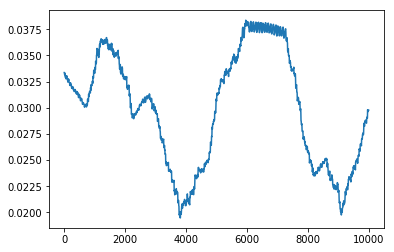

In [35]:
fig, ax= plt.subplots()
ax.plot(times, val[:,1])

In [22]:
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000029978431428e+04
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=1.5754637080804735e-05 y=5.552715431442515e-06 z=-1.1669878145708697e-08 vx=-7.301349514488498e-06 vy=4.705456663283622e-05 vz=-1.0008721700251636e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=0.18820747244699707 y=0.9983892059722129 z=-0.006260219550608885 vx=-6.069045419128382 vy=1.1841416303639263 vz=-0.03798729681251473>
<rebound.Particle object, m=1.2444171101394952e-05 x=-1.3363731009885487 y=-0.7954836546826433 z=0.0021957760487688422 vx=2.628852215552226 vy=-4.19628486689365 vz=0.023007745192562795>
<rebound.Particle object, m=2.531702420746453e-07 x=0.4956723760588331 y=1.4533313436553013 z=0.036701363708389 vx=-4.850118344763209 vy=1.7624426656878491 vz=

In [14]:
sim.integrate(t1, exact_finish_time=0)
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

In [15]:
sim = sa[1]
sim.integrator_synchronize()
sim.status()

---------------------------------
REBOUND version:     	3.8.1
REBOUND built on:    	Mar  6 2019 14:13:11
Number of particles: 	4
Selected integrator: 	whfast
Simulation time:     	1.0000000173176938e+06
Current timestep:    	0.034641
---------------------------------
<rebound.Particle object, m=0.9999960150799597 x=-3.658542143467641e-06 y=-1.949623323935794e-05 z=9.470806349629878e-08 vx=6.872767724455177e-05 vy=-3.73442855666929e-06 vz=3.496108378488267e-07>
<rebound.Particle object, m=3.984920040268468e-06 x=-0.8738958364059268 y=0.4817517647367535 z=-0.003159573737010137 vx=-2.9307195320280233 vy=-5.572709926922893 vz=0.0012280114770667806>
<rebound.Particle object, m=1.2444171101394952e-05 x=0.6063431581766432 y=1.4011530424916374 z=-0.007375445763490789 vx=-4.553768175624738 vy=2.174789434522493 vz=-0.026555396336484776>
<rebound.Particle object, m=2.531702420746453e-07 x=-1.5977605108526833 y=0.5538766686714539 z=0.03817301570906049 vx=-1.5043238809838 vy=-4.4327274873988936 vz=

# Resonant Parameters

The functions in generate_data/resonant/ that generated the initial conditions are not machine independent, so when we run through the same function (i.e. run_resonant in runfunctions.py) with the same seed, we might get one bit different on the end, and that will not yield the same REBOUND integration. So some realizations go unstable in the 1e4 orbit window we give it while others do not. 

In exploreresonantsample.ipynb (messy) in this folder, I crawled the Sunnyvale cluster output files (e.g. stab.o273247) to get the original, seed (for the integration we save an SA for that went more than 1e4 orbits), j, k, Zstar, libfac and Zcom values that I was printing out in each integration in runfunctions.py. That was saved in data.csv and included the instability times. I've split off the times to just have the input parameters and saved that in inputresonantparams.csv. These are presumably reproducible in principle on sunnyvale, but I don't get the same seeds when I try on gandalf. I don't think this is a big deal. This is just our list of input parameters that was used to get our set of simulation_archives. You could then just load our simulation_archives, but you can't get out libfac from the simulation. You could also use run_resonant in runfunctions.py, passing it the seed in the dataframe and get approximate values again, but it wouldn't yield bit by bit the same simulation archives. Again I think this is fine

In [16]:
df = pd.read_csv(path+'data/resonant/inputresonantparams.csv', index_col=0)
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803


In [17]:
import random
import numpy as np
from celmech import Andoyer, Poincare, AndoyerHamiltonian
from celmech.andoyer import get_Xstarres
import rebound
from scipy.integrate import ode

def logunif(r, mini, maxi):
    logmin = np.log10(mini)
    logmax = np.log10(maxi)
    return 10**(r.uniform(logmin, logmax))

def get_resonant(seed, Nplanets=3):
    r = random.Random()
    r.seed(seed)

    Phiprimecrits = [0, 1., -2./3.]
    pairs = ['inner', 'outer', 'split']
    
    k=r.randint(1,2) 
    pairindex=r.randint(0,2)
    pair = pairs[pairindex]
    m1 = logunif(r, 1.e-7, 1.e-4)
    m2 = logunif(r, 1.e-7, 1.e-4)
    eH = ((m1+m2)/3.)**(1./3.)
    ehillstable = 3.5*eH
    jmax = k/(1-1/(1+3.5*eH)**1.5)
    if pair == 'split':
        if Nplanets == 2:
            return # don't want 2planet systems 60 hill radii apart
        maxHillradii = 60. # 3rd planet will go in middle so draw up to 60
    else:
        maxHillradii = 30.
    jmin = max(k+1, k/(1-1/(1+maxHillradii*eH)**1.5))
    j = r.randint(np.ceil(jmin), int(np.floor(jmax)))
    a1 = 1.
    a2 = (float(j)/(j-k))**(2./3.)
    ecross1 = (a2-a1)/a1
    ecross2 = (a2-a1)/a2
    emin1 = m2/ecross1**2
    emin2 = m1/ecross2**2
    emin = max(emin1, emin2) # take as min Z the larger of the kicks a planet gets at conjunction       
    emin = max(emin, (m1+m2)**(1./k)) # below mtot^1/k, the resonant term is smaller than the second order mass terms we ignore
    emax = min(ecross1, ecross2)
    
    avars = Andoyer(j=j,k=k,X=0,Y=0,m1=m1, m2=m2)
    Phiprimecrit = Phiprimecrits[k]
    Xcrit = get_Xstarres(k, Phiprimecrit)
    Phicrit = 0.5*Xcrit**2
    emin = max(avars.Phi_to_Z(Phicrit), emin) # first quantity is value of Z at bifurcation when res first appears
    
    Zstar=logunif(r, emin, emax)
    libfac=logunif(r, 3.e-2, 3)
    negative = r.randint(0,1)
    if negative:
        libfac *= -1
    
    avars = Andoyer.from_elements(j=j,k=k,Zstar=Zstar,libfac=libfac, m1=m1, m2=m2, Zcom=logunif(r, emin,emax), phiZcom=r.uniform(0,2*np.pi), theta=r.uniform(0,2*np.pi), theta1=r.uniform(0,2*np.pi))
    tmax = r.uniform(0,10*avars.tlib)
    H = AndoyerHamiltonian(avars)
    H.integrate(tmax)
    pvars = avars.to_Poincare()
    ps = pvars.particles
    if Nplanets==3:
        m3 = logunif(r, 1.e-7, 1.e-4)
        pvarssorted = Poincare(G=pvars.G)

        if pair == "inner":
            eH = ((m2+m3)/3.)**(1./3.)
            beta = r.uniform(3.5,30)
            a3 = a2*(1+beta*eH)
            ecross3 = (a3-a2)/a3
            emin3 = m2/ecross3**2
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))

        elif pair == "outer":
            eH = ((m1+m3)/3.)**(1./3.)
            beta = r.uniform(3.5,30)
            a3 = a1/(1+beta*eH)
            ecross3 = (a1-a3)/a3
            emin3 = m1/ecross3**2
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)

        elif pair == "split":
            eH1 = ((m1+m3)/3.)**(1./3.)
            eH2 = ((m2+m3)/3.)**(1./3.)
            amin = a1*(1+3.5*eH1)
            amax = min(a1*(1+30*eH1), a2/(1+3.5*eH2))
            if amin > amax:
                seed += 900000
                return get_resonant(seed=seed) # draw new sample (may not be 'split')
            a3 = r.uniform(amin, amax)
            ecross3 = min((a3-a1)/a1, (a2-a3)/a3)
            emin3 = max(m1/((a3-a1)/a3)**2, m2/((a2-a3)/a3)**2)
            e3 = logunif(r, emin3, ecross3)
            pvarssorted.add(m=ps[1].m, M=ps[1].M, a=ps[1].a, e=ps[1].e, gamma=ps[1].gamma, l=ps[1].l)
            pvarssorted.add(m=m3, M=1, a=a3, e=e3, gamma=r.uniform(0, 2*np.pi), l=r.uniform(0, 2*np.pi))
            pvarssorted.add(m=ps[2].m, M=ps[2].M, a=ps[2].a, e=ps[2].e, gamma=ps[2].gamma, l=ps[2].l)
        
        sim = pvarssorted.to_Simulation()
    else:
        sim = avars.to_Simulation()
    # add inclinations and scale s.t. a1 = 1, Mprimary=1. and G = 4*pi**2
    ps = sim.particles
    dscale = ps[1].a
    mscale = ps[0].m
    tscale = np.sqrt(4*np.pi**2*dscale**3/mscale) # = ps[1].P to within mass ratio
    
    siminc = rebound.Simulation()
    siminc.G = sim.G*mscale/dscale**3*tscale**2
    siminc.add(m=ps[0].m/mscale, x=ps[0].x/dscale, y=ps[0].y/dscale, vx=ps[0].vx/dscale*tscale, vy=ps[0].vy/dscale*tscale)
    for p in ps[1:]:
        siminc.add(m=p.m/mscale, a=p.a/dscale, e=p.e, inc=logunif(r, 1.e-3, 1.e-1), Omega=r.uniform(0,2*np.pi), pomega=p.pomega, l=p.l)
        rH = siminc.particles[-1].a*(siminc.particles[-1].m/3./siminc.particles[0].m)**(1./3.) 
        siminc.particles[-1].r = rH
    siminc.move_to_com()
    siminc.integrator="whfast"
    siminc.dt = 2.*np.sqrt(3)/100.*siminc.particles[1].P
    siminc.ri_whfast.safe_mode=0
    siminc.collision="line"
    return siminc, avars

def run_resonant(seed, runstr, Nplanets=3, maxorbs=1.e9, shadow=False):
    success=False
    while not success:
        try:
            sim, avars = get_resonant(seed, Nplanets)
            sim.integrate(1.e4*sim.particles[1].P)
            success=True
        except rebound.Collision:
            seed += 700000 # roughly relatively prime with amin > amax offset above
            
    sim, avars = get_resonant(seed, Nplanets) # get same sim
    return sim, avars, seed

For example, if we feed a seed of 0 for the first row, we should get back a seed of 3500000, but instead get (see above)

In [18]:
row = df.loc[0]
sim, avars, seed = run_resonant(0, row['runstring'])
print(seed)

/home/dtamayo/miniconda3/envs/p3/lib/python3.7/site-packages/scipy/integrate/_ode.py:1348: UserWarning: lsoda: Excess work done on this call (perhaps wrong Dfun type).
  self.messages.get(istate, unexpected_istate_msg)))


700000


Check that you get roughly the same resonant parameters if we feed it the seed used on sunnyvale:

In [19]:
df.head()

,runstring,seed,pairindex,j,k,Zstar,libfac,Zcom
0,0000000.bin,3500000,1,12,1,0.021650,0.007181,0.041669
1,0000001.bin,700001,1,19,2,0.060291,0.523204,0.010656
2,0000002.bin,2,0,6,1,0.026353,0.012995,0.050319
3,0000003.bin,2100003,0,5,2,0.023511,0.713415,0.102200
4,0000004.bin,700004,0,12,1,0.017473,0.003612,0.039803


In [20]:
filename = path+'data/resonant/simulation_archives/runs/sa'+row['runstring']
sa = rebound.SimulationArchive(filename)
sim = sa[0]
avars = Andoyer.from_Simulation(sim, row['j'], row['k'], i1=2, i2=3)
print(avars.Zstar, avars.Zcom)

0.021644667626835583 0.0416691237878827


/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:89: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Binary file was saved with a different version of REBOUND. Binary format might have changed.
  warnings.warn(message, RuntimeWarning)
/mnt/ssd/workspace/rebound/rebound/simulationarchive.py:138: RuntimeWarning: Encountered unkown field in file. File might have been saved with a different version of REBOUND.
  warnings.warn(message, RuntimeWarning)


I think there's some information loss going to andoyer and back from the fact that we have to do the averaging, but we get the same answer to several digits, which should be good enough for ML